# Question 2

Fold the BatchNorm layer into a linear layer at the time of inference

## Prepare dataset as before

In [1]:
with open('../names.txt', "r") as file:
    names = file.read().splitlines()

len(names)

32033

In [2]:
chars = sorted(list(set("".join(name for name in names))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [3]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, char in enumerate(chars):
    stoi[char] = i + 1
    itos[i + 1] = char

len(stoi), len(itos)

(27, 27)

In [4]:
import random

def split_dataset(names, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    # Ensure the ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1"
    
    # Set the random seed for reproducibility
    random.seed(seed)
    
    # Shuffle the names
    random.shuffle(names)
    
    # Calculate the split indices
    total = len(names)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    
    # Split the dataset
    train_names = names[:train_end]
    val_names = names[train_end:val_end]
    test_names = names[val_end:]
    
    return train_names, val_names, test_names

# Split the dataset
train_names, val_names, test_names = split_dataset(names)

# Print the lengths of each split to verify
print(f"Train set size: {len(train_names)}")
print(f"Validation set size: {len(val_names)}")
print(f"Test set size: {len(test_names)}")

Train set size: 25626
Validation set size: 3203
Test set size: 3204


In [5]:
import torch

def create_dataset(names, window_size=3):
    X, y = [], []

    for name in names:
        name = ['.'] * window_size + list(name) + ['.']

        for i, ch in enumerate(name[window_size:]):
            input_context = name[i:i + window_size]
            X.append([stoi[c] for c in input_context])
            y.append(stoi[ch])

    X = torch.tensor(X).long()
    y = torch.tensor(y).long()

    return X, y

In [6]:
# Create training dataset
X_train, y_train = create_dataset(train_names)

# Create validation dataset
X_val, y_val = create_dataset(val_names)

# Create test dataset
X_test, y_test = create_dataset(test_names)

# Print the shapes of the datasets to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([182625, 3]), y_train shape: torch.Size([182625])
X_val shape: torch.Size([22655, 3]), y_val shape: torch.Size([22655])
X_test shape: torch.Size([22866, 3]), y_test shape: torch.Size([22866])


## Define the layers: Linear, BatchNorm1d, Tanh

In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True, generator=None):
        self.weights = torch.randn((fan_in, fan_out), generator=generator, dtype=torch.float32) / ((fan_in) ** 0.50)
        self.bias = bias
        if self.bias:
            self.biases = torch.zeros(fan_out).float()

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias:
            self.out += self.biases

        return self.out
    
    def params(self):
        return [self.weights] + ([self.biases] if self.bias else [])
    
class BatchNorm1d:
    def __init__(self, nfeatures, momentum=0.10, epsilon=1e-5):
        self.gamma = torch.ones(nfeatures).float()
        self.beta = torch.zeros(nfeatures).float()

        self.running_mean = torch.zeros(nfeatures).float()
        self.running_var = torch.ones(nfeatures).float()

        self.training = True

        self.momentum = momentum
        self.epsilon = epsilon

    def __call__(self, x):
        if self.training:
            mean = torch.mean(x, dim=0, keepdim=True)
            var = torch.var(x, dim=0, keepdim=True)
        else:
            mean = self.running_mean
            var = self.running_var

        self.out = (x - mean) / torch.sqrt(var + self.epsilon)
        self.out = self.gamma * self.out + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var

        return self.out
    
    def params(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def params(self):
        return []

## Create model and train

In [38]:
def create_model(emb_dim, hidden_dim, window_size, vocab_size):
    g = torch.Generator().manual_seed(2147483647)

    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32, generator=g)

    layers = [
        Linear(emb_dim * window_size, hidden_dim, bias=False), BatchNorm1d(hidden_dim, momentum=0.005), Tanh(),
        Linear(hidden_dim, vocab_size, bias=False), BatchNorm1d(vocab_size, momentum=0.005)
    ]

    params = [C] + [param for layer in layers for param in layer.params()]

    # Reduce confidence of the last layer
    layers[-1].gamma.data *= 0.10
    # Kaiming init linear layers
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weights.data *= 5/3

    # Make them optimisable
    for p in params:
        p.requires_grad = True

    print(f"Number of parameters: {sum([p.numel() for p in params])}")

    return layers, params

In [39]:
def train(X, y, params, layers, n_iters, batch_size, lr_schedule):
    g = torch.Generator().manual_seed(2147483647)
    stepi, lossi = [], []

    for i in range(n_iters):
        #Create batch
        batch = torch.randint(0, len(X), (batch_size,), generator=g)
        X_batch, y_batch = X[batch], y[batch]

        # forward
        emb = params[0][X_batch]
        h = emb.view(batch_size, -1)
        for layer in layers:
            h = layer(h)
        logits = h

        # loss computation
        loss = torch.nn.functional.cross_entropy(logits, y_batch)

        # Set param grads to None
        for p in params:
            p.grad = None

        # backward
        loss.backward()

        lr = lr_schedule(i)
        # update params
        with torch.no_grad():
            for p in params:
                p.data -= lr * p.grad

        stepi.append(i)
        lossi.append(loss.item())

        if i % 10000 == 0:
            print(f" Step {i}/{n_iters} --> {loss.item()}")

    return stepi, lossi

In [40]:
layers, params = create_model(emb_dim=10, hidden_dim=400, window_size=3, vocab_size=len(stoi))

Number of parameters: 23924


In [41]:
stepi, lossi = train(X_train, y_train, params, layers,\
                      n_iters=200000, batch_size=128, lr_schedule=lambda i: 10**(-0.95) if i<100000 else 10**(-1.95))

 Step 0/200000 --> 3.308393955230713
 Step 10000/200000 --> 2.0729734897613525
 Step 20000/200000 --> 2.118445873260498
 Step 30000/200000 --> 1.9467620849609375
 Step 40000/200000 --> 1.9567582607269287
 Step 50000/200000 --> 2.151818037033081
 Step 60000/200000 --> 1.9391140937805176
 Step 70000/200000 --> 1.9172179698944092
 Step 80000/200000 --> 2.1447908878326416
 Step 90000/200000 --> 2.087392568588257
 Step 100000/200000 --> 2.069159746170044
 Step 110000/200000 --> 1.991887092590332
 Step 120000/200000 --> 2.256371259689331
 Step 130000/200000 --> 2.0090086460113525
 Step 140000/200000 --> 2.2035090923309326
 Step 150000/200000 --> 1.8689044713974
 Step 160000/200000 --> 2.088925361633301
 Step 170000/200000 --> 2.1653757095336914
 Step 180000/200000 --> 1.8291077613830566
 Step 190000/200000 --> 1.944381594657898


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

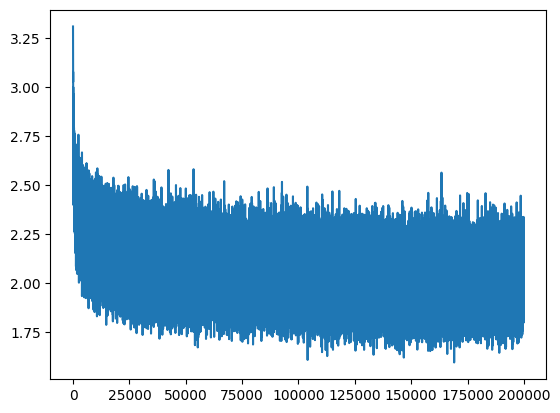

In [43]:
plt.plot(stepi, lossi)

## Get the losses using both methods 

### Default forward

In [46]:
@torch.no_grad()
def compute_loss(X, y, params, layers):
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False

    inp = params[0][X]
    h = inp.view(len(X), -1)
    for layer in layers:
        h = layer(h)

    logits = h
    loss = torch.nn.functional.cross_entropy(logits, y)
    return loss.item()

In [47]:
train_loss = compute_loss(X_train, y_train, params, layers)
val_loss = compute_loss(X_val, y_val, params, layers)
test_loss = compute_loss(X_test, y_test, params, layers)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 1.9813603162765503
Validation Loss: 2.0832407474517822
Test Loss: 2.0805985927581787


### Combined forward

In [51]:
@torch.no_grad()
def compute_loss_combined(X, y, params, layers, emb_dim, hidden_dim, window_size, vocab_size):
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False

    combined_layers = [
        Linear(emb_dim * window_size, hidden_dim), Tanh(),
        Linear(hidden_dim, vocab_size)
    ]

    # Initialize first Linear from the 1st Linear and BatchNorm
    combined_layers[0].weights.data = (layers[0].weights.data * layers[1].gamma.data) / torch.sqrt(layers[1].running_var.data + layers[1].epsilon)
    combined_layers[0].biases.data = layers[1].beta.data - (layers[1].running_mean.data * layers[1].gamma.data) / torch.sqrt(layers[1].running_var.data + layers[1].epsilon)

    # Initialize second Linear from the 2nd Linear and BatchNorm
    combined_layers[2].weights.data = (layers[3].weights.data * layers[4].gamma.data) / torch.sqrt(layers[4].running_var.data + layers[4].epsilon)
    combined_layers[2].biases.data = layers[4].beta.data - (layers[4].running_mean.data * layers[4].gamma.data) / torch.sqrt(layers[4].running_var.data + layers[4].epsilon)
    
    inp = params[0][X]
    h = inp.view(len(X), -1)
    for layer in combined_layers:
        h = layer(h)

    logits = h
    loss = torch.nn.functional.cross_entropy(logits, y)
    return loss.item()

In [52]:
train_loss = compute_loss_combined(X_train, y_train, params, layers, emb_dim=10, hidden_dim=400, window_size=3, vocab_size=len(stoi))
val_loss = compute_loss_combined(X_val, y_val, params, layers, emb_dim=10, hidden_dim=400, window_size=3, vocab_size=len(stoi))
test_loss = compute_loss_combined(X_test, y_test, params, layers, emb_dim=10, hidden_dim=400, window_size=3, vocab_size=len(stoi))

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 1.9813603162765503
Validation Loss: 2.0832407474517822
Test Loss: 2.080598831176758


### Sample

In [53]:
emb_dim=10; hidden_dim=400; window_size=3; vocab_size=len(stoi);

combined_layers = [
    Linear(emb_dim * window_size, hidden_dim), Tanh(),
    Linear(hidden_dim, vocab_size)
]

with torch.no_grad():
    # Initialize first Linear from the 1st Linear and BatchNorm
    combined_layers[0].weights.data = (layers[0].weights.data * layers[1].gamma.data) / torch.sqrt(layers[1].running_var.data + layers[1].epsilon)
    combined_layers[0].biases.data = layers[1].beta.data - (layers[1].running_mean.data * layers[1].gamma.data) / torch.sqrt(layers[1].running_var.data + layers[1].epsilon)

    # Initialize second Linear from the 2nd Linear and BatchNorm
    combined_layers[2].weights.data = (layers[3].weights.data * layers[4].gamma.data) / torch.sqrt(layers[4].running_var.data + layers[4].epsilon)
    combined_layers[2].biases.data = layers[4].beta.data - (layers[4].running_mean.data * layers[4].gamma.data) / torch.sqrt(layers[4].running_var.data + layers[4].epsilon)

In [64]:
g = torch.Generator().manual_seed(2147483647 + 10)

with torch.no_grad():
    for i in range(20):
        curr_name, curr_window = "", "." * window_size

        while True:
            inp = [stoi[ch] for ch in curr_window]
            inp = torch.tensor(inp).long().view(1, -1)
            
            emb = params[0][inp]
            h = emb.view(1, -1)
            for layer in combined_layers:
                h = layer(h)

            logits = h
            probs = torch.softmax(logits.view(-1), dim=0)
            # print(probs.shape)

            sampled_idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            sampled_char = itos[sampled_idx]

            if sampled_char == '.':
                break
            curr_name += sampled_char
            curr_window += sampled_char
            curr_window = curr_window[1:]

        print(curr_name)

carmahela
jhovi
kimri
reh
cassanden
jazon
nadeliah
jareen
nellara
chaily
kaleigh
ham
port
quinthorline
liven
corterri
jarisi
jaxsenick
brex
edi
